In [1]:
%matplotlib inline
import skyflux as sf

Missing flux value for: GLEAM J202818-254302 at frequency: 204 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 212 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 220 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 227 MHz.
Missing spectral index for: GLEAM J202818-254302


//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pos1_Elm_samples = h5f["pos1_Elm"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.neg1_Elm_samples = h5f["neg1_Elm"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.freq_nodes = h5f["frequencies"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.L_model = h5f["spatial_bandlimit"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:22: H5pyDeprec

delta_nu_in is 1000000.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [3]:
arbitrary_source = sf.catalog.obj_catalog[999]
arb_ra = arbitrary_source.ra_angle
arb_dec = arbitrary_source.dec_angle
J = sf.stokes.create_J(ra=arb_ra, dec=arb_dec)
J.shape
J

array([[[ 0.01138831+0.00810221j,  0.01442605+0.00194914j],
        [-0.01194005+0.00040515j,  0.0138295 -0.00603036j]]])

In [4]:
arb_ra = sf.rot.get_lst(radians=False)
arb_dec = sf.rot.hera_lat
print(sf.rot.hera_lat)
J = sf.stokes.create_J(ra=arb_ra, dec=arb_dec, lst=sf.rot.get_lst(radians=False), radians=False)

-30.72138888888889


In [5]:
J

array([[[ 8.12625503e-01-5.82786230e-01j,
         -2.76878357e-05-3.19740612e-05j],
        [ 2.76878377e-05+3.19740640e-05j,
          8.12625503e-01-5.82786230e-01j]]])

In [6]:
Am = sf.stokes.create_A(ra=arb_ra, dec=arb_dec, radians=False)
print(Am)
Am.shape

[[[ 9.99999996e-01-7.21490734e-11j -2.17287642e-05-2.03919731e-05j
    2.03901973e-05-2.17269884e-05j  1.33692932e-06-4.21189581e-05j]]

 [[-2.03920070e-05+2.17287991e-05j  1.00004211e+00+1.33682938e-06j
    1.72097336e-10+3.82950376e-11j  2.17287991e-05+2.03920070e-05j]]

 [[ 2.17270233e-05+2.03902312e-05j  1.03322240e-10+3.72281057e-11j
    9.99957876e-01-1.33675385e-06j -2.03902312e-05+2.17270233e-05j]]

 [[-1.33665390e-06+4.21190336e-05j  2.03919731e-05-2.17287642e-05j
   -2.17269884e-05-2.03901973e-05j  9.99999996e-01-3.37406987e-12j]]]


(4, 1, 4)

In [7]:
Am[0][0][0]

(0.0003964137491680832-2.74689336109616e-06j)

In [8]:
# Display available antennae
print(sf.demo.active_ants)

[0, 1, 2, 11, 12, 13, 14, 23, 24, 25, 26, 27, 36, 37, 38, 39, 40, 41, 50, 51, 52, 53, 54, 55, 65, 66, 67, 68, 69, 70, 71, 82, 83, 84, 85, 86, 87, 88, 98, 120, 121, 122, 123, 124, 136, 137, 138, 139, 140, 141, 142, 143]


In [9]:
# we sample three arbitrary sources, and 2/3 are zero
print(arbitrary_source)
print(sf.vis.visibility(2, 11, arbitrary_source))

print(sf.vis.visibility(36, 37, sf.catalog.obj_catalog[981]))
print(sf.vis.visibility(88, 121, sf.catalog.obj_catalog[134]))
# also, would we not expect the first term to dominate? And yet it is not even the largest
    # of numbers all with magnitudes less than one

Name: GLEAM J185915-381842
Right ascension: 284.8155
Declination: -37.688250000000004
151 MHz flux: 1.2316479999999999



AttributeError: module 'skyflux.stokes' has no attribute 'A_matrix'

In [10]:
"""
This section kills the kernel! Do NOT run it!!
I am leaving it here as a to-do of sorts. I think, that my inability
to run it in this environment may be a bad sign.
(It does work fine in the shell, so far as I can tell.)

t = 0
arg = 134

obj = flux.catalog.obj_catalog[arg]
ra = np.radians(obj.ra_angle)
dec = np.radians(obj.dec_angle)
while t < 2 * np.pi:
    print(t)
    t += np.pi / 72
    
    print(flux.stokes.J_matrix(ra, dec, t))
    print("\n")

"""

'\nThis section kills the kernel! Do NOT run it!!\nI am leaving it here as a to-do of sorts. I think, that my inability\nto run it in this environment may be a bad sign.\n(It does work fine in the shell, so far as I can tell.)\n\nt = 0\narg = 134\n\nobj = flux.catalog.obj_catalog[arg]\nra = np.radians(obj.ra_angle)\ndec = np.radians(obj.dec_angle)\nwhile t < 2 * np.pi:\n    print(t)\n    t += np.pi / 72\n    \n    print(flux.stokes.J_matrix(ra, dec, t))\n    print("\n")\n\n'

In [11]:
vist = skyflux.vis.source_over_time(
    88, 121, arbitrary_source, 0, 2/3 * np.pi, np.pi / 72
)
vist

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 

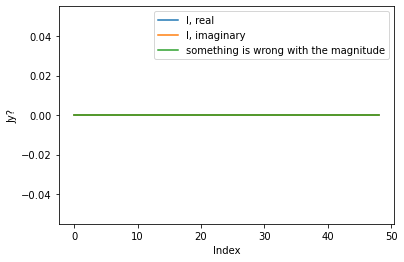

In [12]:
plt.plot(np.real(vist[:, 0]), label="I, real")
plt.plot(np.imag(vist[:, 0]), label="I, imaginary")
plt.plot(np.abs(vist[:, 0]), label="something is wrong with the magnitude")

plt.xlabel("Index")
plt.ylabel("Jy?")

plt.legend()

plt.show()

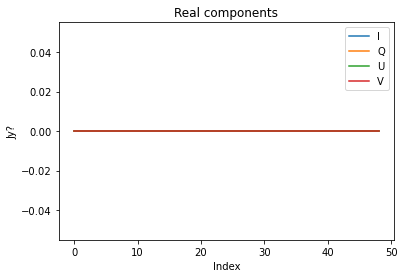

In [13]:
plt.plot(np.real(vist[:, 0]), label="I")
plt.plot(np.real(vist[:, 1]), label="Q")
plt.plot(np.real(vist[:, 2]), label="U")
plt.plot(np.real(vist[:, 3]), label="V")

plt.xlabel("Index")
plt.ylabel("Jy?")
plt.title("Real components")

plt.legend()

plt.show()

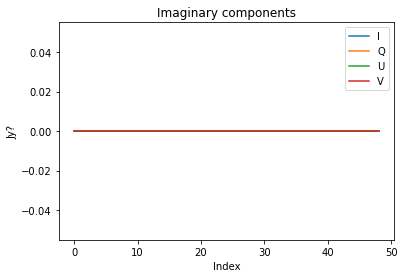

In [14]:
plt.plot(np.imag(vist[:, 0]), label="I")
plt.plot(np.imag(vist[:, 1]), label="Q")
plt.plot(np.imag(vist[:, 2]), label="U")
plt.plot(np.imag(vist[:, 3]), label="V")

plt.xlabel("Index")
plt.ylabel("Jy?")
plt.title("Imaginary components")

plt.legend()

plt.show()

In [15]:
vist = flux.vis.source_over_time(
    88, 121, arbitrary_source, 0, 2/3 * np.pi, np.pi / 72
)
plt.plot(np.real(vist[:, 0]), label="I, real")
plt.plot(np.imag(vist[:, 0]), label="I, imaginary")
plt.plot(np.abs(vist[:, 0]), label="something is wrong with the magnitude")

plt.xlabel("Index")
plt.ylabel("Jy?")

plt.legend()

plt.show()

NameError: name 'flux' is not defined